# IMPORTS

In [ ]:
# general imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from textblob import TextBlob  
from collections import Counter
import random
import torch
from sklearn.model_selection import train_test_split

# import for utility
from src.utils.data_utils import *
from src.utils.evaluation_utils import *
from src.utils.general_utils import *

# import for models 
from src.models.sentiment_analysis import *
from src.models.crossvalidation import *
from src.models.neural_network import *

# SETTINGS

In [2]:
SETTINGS = {
    "DATA_RUTE": r"data/",
    "ORIGINAL_DATA_RUTE": r"data/original_data/",
    "DATA_VERSION": 3,
    
    "MODEL_SETTINGS":{
        "LAYER_SIZE": 128,
        "GENRE_THRESHOLD": 0.5,
        "TEST_SET": 0,
        "TEST_PROPORTION": 0.2,
        "SEED": 42,
    },
}

# DATA LOADING

In [3]:
# Load movie data

MOVIES = load_movie_data(SETTINGS)
MOVIES.head()

c:\Users\fredr\Desktop\CS-401\ada-2024-project-alpacadreamagency\src\utils\data_utils.py:93: DtypeWarning: Columns (0,2,3,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
c:\Users\fredr\Desktop\CS-401\ada-2024-project-alpacadreamagency\src\utils\data_utils.py:103: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year


wikipedia_movie_ID                                               name  \
0              975900                                     ghosts of mars   
1             3196793  getting away with murder: the jonbenét ramsey ...   
2            13696889                                      the gangsters   
3            10408933                           alexander's ragtime band   
4             2345652                                   city of the dead   

  release_date     revenue  runtime  \
0   2001-08-24  14010832.0     98.0   
1   2000-02-16         NaN     95.0   
2   1913-05-29         NaN     35.0   
3   1938-08-16   3600000.0    106.0   
4         1960         NaN     76.0   

                                           languages  \
0                 {"/m/02h40lc": "English Language"}   
1                 {"/m/02h40lc": "English Language"}   
2  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
3                 {"/m/02h40lc": "English Language"}   
4                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2  {"/m/09c7w0": "United States of America"}   
3  {"/m/09c7w0": "United States of America"}   
4             {"/m/07ssc": "United Kingdom"}   

                                              genres  release_year  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...          2001   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...          2000   
2  {"/m/02hmvc": "Short Film", "/m/06ppq": "Silen...          1913   
3  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...          1938   
4  {"/m/03npn": "Horror", "/m/0fdjb": "Supernatur...             0   

  vote_average vote_count release_date_new revenue_new runtime_new  adult  \
0        5.127        977       2001-08-24    14010832          98  False   
1          0.0          0       2000-02-16           0          60  False   
2          6.0          1       1913-05-29           0          35  False   
3          6.6         23       1938-05-24     4000000         106  False   
4          0.0          0              NaN           0          77  False   

     budget                                           overview popularity  \
0  28000000  In 2176, a Martian police unit is sent to pick...     14.189   
1         0  Dramatization of the story behind the murder o...        0.6   
2         0  An amusing burlesque of gang fighters. The pol...        0.6   
3   2000000  Classical violinist, Roger Grant disappoints h...      2.522   
4         0  This is vintage horror stuff. A sleepy northea...        0.6   

   release_year_new  
0              2001  
1              2000  
2              1913  
3              1938  
4                 0

In [4]:
# Load character data
CHARACTER = load_character_data(SETTINGS)
CHARACTER.head()

Wikipedia movie ID Freebase movie ID Movie release date  \
0              975900         /m/03vyhn         2001-08-24   
1              975900         /m/03vyhn         2001-08-24   
2              975900         /m/03vyhn         2001-08-24   
3              975900         /m/03vyhn         2001-08-24   
4              975900         /m/03vyhn         2001-08-24   

               Character name Actor date of birth Actor gender  \
0                    Akooshay          1958-08-26            F   
1  Lieutenant Melanie Ballard          1974-08-15            F   
2         Desolation Williams          1969-06-15            M   
3          Sgt Jericho Butler          1967-09-12            M   
4             Bashira Kincaid          1977-09-25            F   

   Actor height (in meters) Actor ethnicity (Freebase ID)          Actor name  \
0                     1.620                           NaN      Wanda De Jesus   
1                     1.780                    /m/044038p  Natasha Henstridge   
2                     1.727                       /m/0x67            Ice Cube   
3                     1.750                           NaN       Jason Statham   
4                     1.650                           NaN         Clea DuVall   

   Actor age at movie release Freebase character/actor map ID  \
0                        42.0                      /m/0bgchxw   
1                        27.0                       /m/0jys3m   
2                        32.0                       /m/0jys3g   
3                        33.0                      /m/02vchl6   
4                        23.0                      /m/02vbb3r   

  Freebase character ID Freebase actor ID  
0            /m/0bgcj3x        /m/03wcfv7  
1            /m/0bgchn4         /m/0346l4  
2            /m/0bgchn_        /m/01vw26l  
3            /m/0bgchnq         /m/034hyc  
4            /m/0bgchp9         /m/01y9xg

In [5]:
# Merge movie df with plots
MOVIES = merge_plot_movies(SETTINGS, MOVIES)
MOVIES.head()

wikipedia_movie_ID                                               name  \
0              975900                                     ghosts of mars   
1             3196793  getting away with murder: the jonbenét ramsey ...   
2            13696889                                      the gangsters   
3            10408933                           alexander's ragtime band   
4             2345652                                   city of the dead   

  release_date     revenue  runtime  \
0   2001-08-24  14010832.0     98.0   
1   2000-02-16         NaN     95.0   
2   1913-05-29         NaN     35.0   
3   1938-08-16   3600000.0    106.0   
4         1960         NaN     76.0   

                                           languages  \
0                 {"/m/02h40lc": "English Language"}   
1                 {"/m/02h40lc": "English Language"}   
2  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
3                 {"/m/02h40lc": "English Language"}   
4                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2  {"/m/09c7w0": "United States of America"}   
3  {"/m/09c7w0": "United States of America"}   
4             {"/m/07ssc": "United Kingdom"}   

                                              genres  release_year  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...          2001   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...          2000   
2  {"/m/02hmvc": "Short Film", "/m/06ppq": "Silen...          1913   
3  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...          1938   
4  {"/m/03npn": "Horror", "/m/0fdjb": "Supernatur...             0   

  vote_average vote_count release_date_new revenue_new runtime_new  adult  \
0        5.127        977       2001-08-24    14010832          98  False   
1          0.0          0       2000-02-16           0          60  False   
2          6.0          1       1913-05-29           0          35  False   
3          6.6         23       1938-05-24     4000000         106  False   
4          0.0          0              NaN           0          77  False   

     budget                                           overview popularity  \
0  28000000  In 2176, a Martian police unit is sent to pick...     14.189   
1         0  Dramatization of the story behind the murder o...        0.6   
2         0  An amusing burlesque of gang fighters. The pol...        0.6   
3   2000000  Classical violinist, Roger Grant disappoints h...      2.522   
4         0  This is vintage horror stuff. A sleepy northea...        0.6   

   release_year_new                                               plot  
0              2001  Set in the second half of the 22nd century, th...  
1              2000                                                NaN  
2              1913                                                NaN  
3              1938                                                NaN  
4                 0                                                NaN

In [6]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'vote_average',
       'vote_count', 'release_date_new', 'revenue_new', 'runtime_new', 'adult',
       'budget', 'overview', 'popularity', 'release_year_new', 'plot'],
      dtype='object')

### Duplicated columns

In [7]:
len(MOVIES["wikipedia_movie_ID"]) - len(MOVIES["wikipedia_movie_ID"].unique())

6023

In [8]:
MOVIES[MOVIES.duplicated(subset=['wikipedia_movie_ID'], keep=False)].sort_values(by="wikipedia_movie_ID", ascending=False).head()

wikipedia_movie_ID    name release_date  revenue  runtime  \
3039            37283373  island          NaN      NaN      NaN   
3040            37283373  island          NaN      NaN      NaN   
3035            37283373  island          NaN      NaN      NaN   
3036            37283373  island          NaN      NaN      NaN   
3037            37283373  island          NaN      NaN      NaN   

                               languages countries                     genres  \
3039  {"/m/02h40lc": "English Language"}        {}  {"/m/01drsx": "Disaster"}   
3040  {"/m/02h40lc": "English Language"}        {}  {"/m/01drsx": "Disaster"}   
3035  {"/m/02h40lc": "English Language"}        {}  {"/m/01drsx": "Disaster"}   
3036  {"/m/02h40lc": "English Language"}        {}  {"/m/01drsx": "Disaster"}   
3037  {"/m/02h40lc": "English Language"}        {}  {"/m/01drsx": "Disaster"}   

      release_year vote_average vote_count release_date_new revenue_new  \
3039             0          0.0          0              NaN           0   
3040             0          0.0          0              NaN           0   
3035             0          0.0          0              NaN           0   
3036             0          0.0          0              NaN           0   
3037             0          0.0          0              NaN           0   

     runtime_new  adult budget  \
3039           4  False      0   
3040           0  False      0   
3035           0  False      0   
3036          13  False      0   
3037           4  False      0   

                                               overview popularity  \
3039  An immigrant in Italy, away from his family wh...        0.6   
3040  A maritime warden investigates an unauthorised...        0.6   
3035          A man lost at sea washes up on an island.        0.6   
3036                                    a short film by        0.6   
3037  A music video by Eli Hayes for Geomi’s track, ...        0.0   

      release_year_new                                               plot  
3039                 0  A Czech-born woman arrives on a Greek island h...  
3040                 0  A Czech-born woman arrives on a Greek island h...  
3035                 0  A Czech-born woman arrives on a Greek island h...  
3036                 0  A Czech-born woman arrives on a Greek island h...  
3037                 0  A Czech-born woman arrives on a Greek island h...

In [9]:
MOVIES.isna().sum()

wikipedia_movie_ID        0
name                      0
release_date           1503
revenue               33109
runtime                6809
languages                 0
countries                 0
genres                    0
release_year              0
vote_average              0
vote_count                0
release_date_new       9951
revenue_new               0
runtime_new               0
adult                     0
budget                    0
overview               2508
popularity                0
release_year_new          0
plot                  15879
dtype: int64

As we can see there are some missing values and duplicated movies...
Lets do some ✨magic✨
### Remove duplicates

In [10]:
MOVIES = remove_duplicate_movies(MOVIES)
len(MOVIES)-len(MOVIES["wikipedia_movie_ID"].unique()) #number of duplicates


0

# DATA WRANGLING

- NANs
- Non sense values
- Gather sub-genre into general genre
- 
  ...

### Recover information from the new dataset if it was missing in the original

In [11]:
MOVIES = recover_from_new_db(MOVIES)

### Release date to year

In [12]:
FIRST_MOVIE_YEAR = 1888
ACTUAL_YEAR = 2024

MOVIES = clean_release_year(MOVIES)
print(f'Fist year: {MOVIES["release_year"].min()}, Last year: {MOVIES["release_year"].max()}')
MOVIES["release_year"]

Fist year: 1894.0, Last year: 2016.0


0        2001.0
1        2000.0
2        1913.0
3        1938.0
5        1997.0
          ...  
33938    1976.0
33939    1960.0
33941    1992.0
33942    1976.0
33943    1989.0
Name: release_year, Length: 29447, dtype: float64

### Parse features to actual numbers

In [13]:
MOVIES = parse_features(MOVIES)
MOVIES.head()

wikipedia_movie_ID                                               name  \
0              975900                                     ghosts of mars   
1             3196793  getting away with murder: the jonbenét ramsey ...   
2            13696889                                      the gangsters   
3            10408933                           alexander's ragtime band   
5             6631279                                        little city   

  release_date     revenue  runtime  \
0   2001-08-24  14010832.0     98.0   
1   2000-02-16         0.0     95.0   
2   1913-05-29         0.0     35.0   
3   1938-08-16   3600000.0    106.0   
5   1997-04-04         0.0     93.0   

                                           languages  \
0                 {"/m/02h40lc": "English Language"}   
1                 {"/m/02h40lc": "English Language"}   
2  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
3                 {"/m/02h40lc": "English Language"}   
5                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2  {"/m/09c7w0": "United States of America"}   
3  {"/m/09c7w0": "United States of America"}   
5  {"/m/09c7w0": "United States of America"}   

                                              genres  release_year  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...        2001.0   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...        2000.0   
2  {"/m/02hmvc": "Short Film", "/m/06ppq": "Silen...        1913.0   
3  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...        1938.0   
5  {"/m/06cvj": "Romantic comedy", "/m/0hj3n0w": ...        1997.0   

   vote_average  ...  release_date_new revenue_new runtime_new adult  \
0         5.127  ...        2001-08-24    14010832          98     0   
1         0.000  ...        2000-02-16           0          60     0   
2         6.000  ...        1913-05-29           0          35     0   
3         6.600  ...        1938-05-24     4000000         106     0   
5         3.833  ...        1997-04-04           0          90     0   

       budget                                           overview popularity  \
0  28000000.0  In 2176, a Martian police unit is sent to pick...     14.189   
1         0.0  Dramatization of the story behind the murder o...      0.600   
2         0.0  An amusing burlesque of gang fighters. The pol...      0.600   
3   2000000.0  Classical violinist, Roger Grant disappoints h...      2.522   
5         0.0  Best friends Adam and Kevin have a lot in comm...      1.556   

   release_year_new                                               plot  \
0              2001  Set in the second half of the 22nd century, th...   
1              2000  Dramatization of the story behind the murder o...   
2              1913  An amusing burlesque of gang fighters. The pol...   
3              1938  Classical violinist, Roger Grant disappoints h...   
5              1997  Adam, a San Francisco-based artist who works a...   

  len_plot  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
5      NaN  

[5 rows x 21 columns]

### Gather sub-genre into general genre

In [14]:
NEW_GENRE = pd.read_csv(f"categories.csv")
NEW_GENRE["subgenres"] = NEW_GENRE["subgenres"].apply(lambda x: ast.literal_eval(x))

NEW_GENRE.head()

categories                                          subgenres
0  Action/Adventure  [Action, Adventure, Action/Adventure, Martial ...
1        Adaptation     [Film adaptation, Remake, Live action, Reboot]
2             Adult  [Sex comedy, Erotica, Erotic thriller, Pornogr...
3         Animation  [Animation, Anime, Computer Animation, Clay an...
4      Asian Movies  [Bollywood, Filipino Movies, Chinese Movies, J...

In [15]:
MOVIES = gather_subgenres(MOVIES, NEW_GENRE)
MOVIES[["original_genres", "new_genres", "genre_hot"]].head()

original_genres  \
0  (Thriller, Science Fiction, Horror, Adventure,...   
1   (Mystery, Biographical film, Drama, Crime Drama)   
2  (Short Film, Silent film, Indie, Black-and-whi...   
3                 (Musical, Comedy, Black-and-white)   
5  (Romantic comedy, Ensemble Film, Comedy-drama,...   

                                          new_genres  \
0  [Action/Adventure, Horror, Science Fiction, Su...   
1  [Crime, Drama, Mystery/Suspense, Non-fiction/E...   
2  [Comedy, Indie, Old-fashioned/classical style,...   
3  [Comedy, Music/Dance, Old-fashioned/classical ...   
5                    [Comedy, Drama, Romance, Other]   

                                           genre_hot  
0  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...

### Remove movies without plot

In [16]:
MOVIES = MOVIES[MOVIES["plot"].notna()]

### Clean not anymore usefull columns

In [17]:
MOVIES = MOVIES.drop(columns=[
    "release_date_new", "revenue_new", "runtime_new", "overview", "release_year_new", "len_plot"
])    

In [18]:
print(f"We end up with: {len(MOVIES)} movies")
MOVIES.isna().sum()

We end up with: 29017 movies


wikipedia_movie_ID    0
name                  0
release_date          0
revenue               0
runtime               0
languages             0
countries             0
genres                0
release_year          0
vote_average          0
vote_count            0
adult                 0
budget                0
popularity            0
plot                  0
original_genres       0
new_genres            0
genre_hot             0
dtype: int64

As we can see we've lost a lot of movies. The majority of them originally had very little information.

Using the new dataset we got back some of that information. And better, now we are going to enrich MORE what we have:

# DATA EXPANSION
### Get the "theme" features for each movie

In [19]:
from src.models.theme_encoding import theme_encoding

column_names = ["death", "love", "tragedy"]
#This is demontration purpose. More keywords will added later.
matrix_themes = pd.DataFrame(theme_encoding(MOVIES['plot']),  columns=column_names)

MOVIES.reset_index(inplace=True, drop=True)
MOVIES[column_names] = matrix_themes
MOVIES[column_names]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fredr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


death      love   tragedy
0      0.500000  0.100000  0.400000
1      1.000000  0.000000  0.000000
2      0.000000  0.000000  0.000000
3      0.000000  0.800000  0.200000
4      0.200000  0.600000  0.200000
...         ...       ...       ...
29012  0.187500  0.562500  0.250000
29013  0.571429  0.428571  0.000000
29014  0.562500  0.375000  0.062500
29015  0.333333  0.666667  0.000000
29016  0.476190  0.190476  0.333333

[29017 rows x 3 columns]

### Sentiment analysis of the plot

In [ ]:
MOVIES['sentiment'] = sentiment_analysis(MOVIES)

MOVIES['sentiment'].head()

0   -0.085095
1   -0.050000
2    0.600000
3    0.441667
4    0.165202
Name: sentiment, dtype: float64

### Character analysis

In [21]:
MOVIES = count_characters(MOVIES, CHARACTER)
MOVIES["Character Count"]

0        17
1        15
2         1
3         4
4         6
         ..
29012    11
29013     6
29014    12
29015    11
29016    10
Name: Character Count, Length: 29017, dtype: int32

In [22]:
actor_counts = count_genders(CHARACTER)
# Display the resulting DataFrame
actor_counts.head()

Actor gender filled  Wikipedia movie ID  Female actor count  Male actor count  \
0                                   330                   4                 0   
1                                  3217                   3                10   
2                                  3333                   6                 8   
3                                  3746                   3                11   
4                                  3837                   2                18   

Actor gender filled  N/A actor count  
0                                  0  
1                                  1  
2                                  0  
3                                  1  
4                                  0

In [23]:
MOVIES = merge_genders_movies(MOVIES, actor_counts)
# Display the updated MOVIES DataFrame with the new columns
MOVIES[["Male actor count", "Female actor count", "N/A actor count"]].head()

Male actor count  Female actor count  N/A actor count
0                11                   6                0
1                11                   4                0
2                 1                   0                0
3                 2                   2                0
4                 2                   4                0

In [26]:
MOVIES = add_actor_per_age(MOVIES, CHARACTER)
MOVIES[column_names].head()

Actors 0-20  Actors 20-30  Actors 30-40  Actors 40-60  Actors 60+
0            0             2             3             7           5
1            1             0             1             6           7
2            0             0             0             0           1
3            0             2             2             0           0
4            0             1             4             1           0

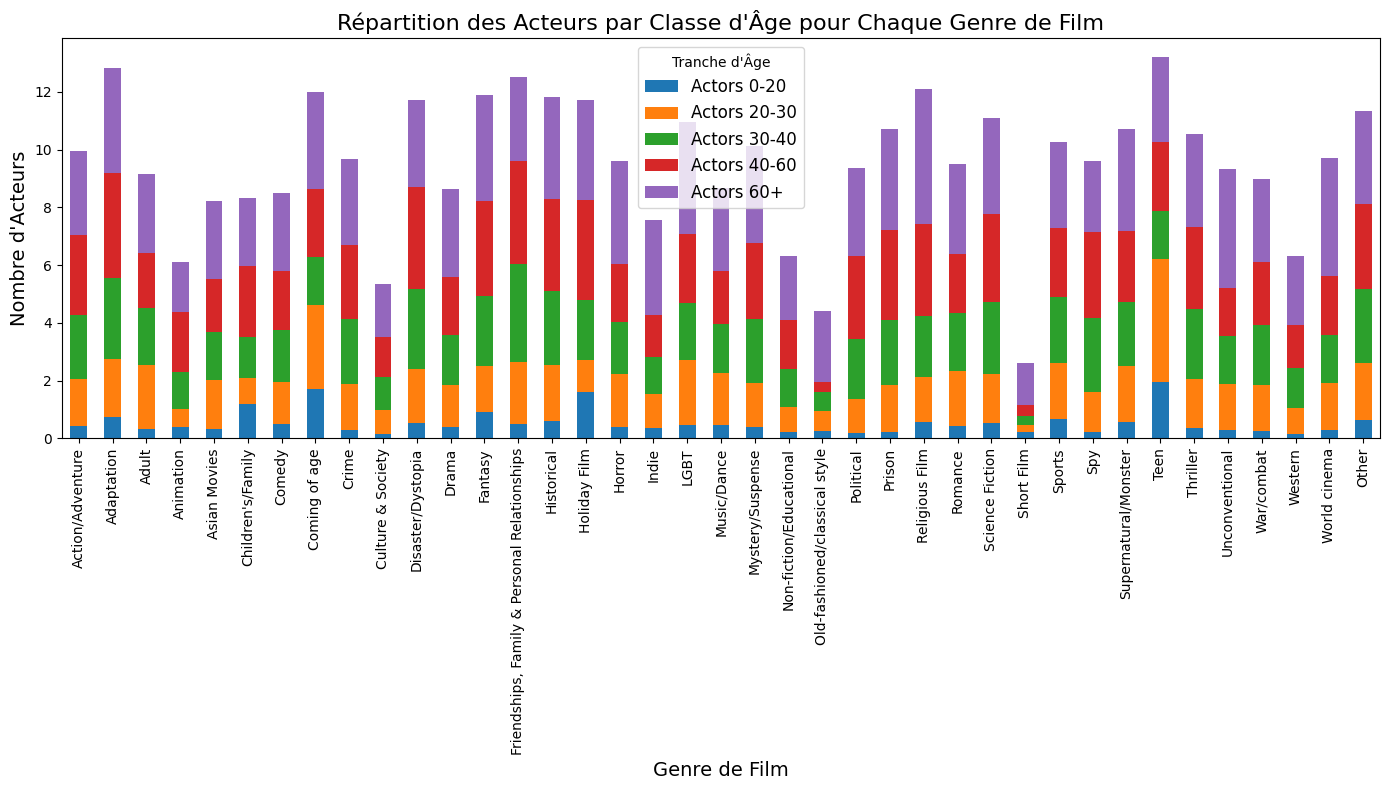

In [27]:
column_names = ['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']
bar_per_genre(MOVIES, NEW_GENRE["categories"], column_names, "Répartition des Acteurs par Classe d'Âge pour Chaque Genre de Film",
                      "Genre de Film", "Nombre d'Acteurs", "Tranche d'Âge", stacked=True)

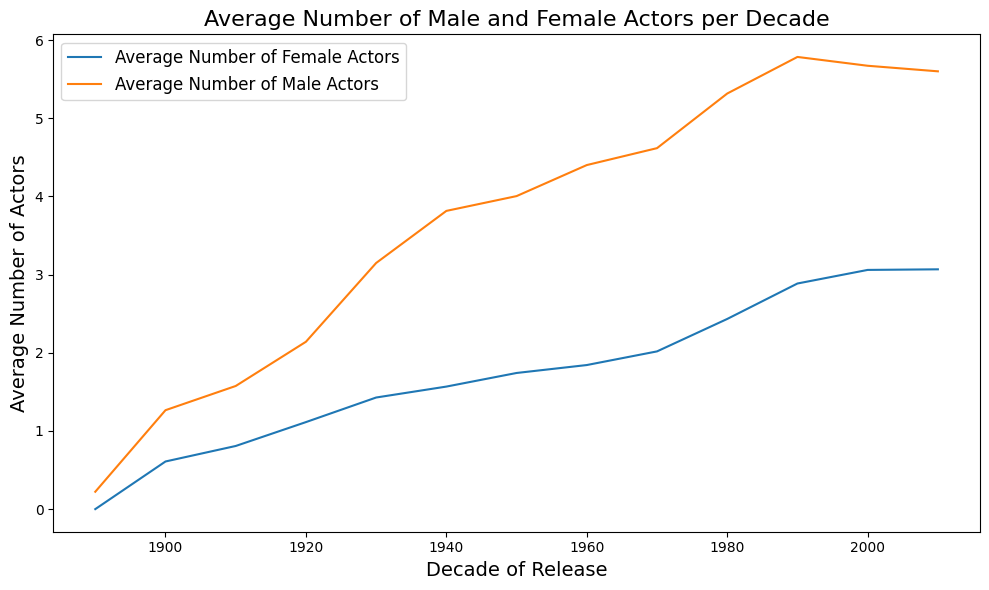

In [30]:
# Plot the average number of male and female actors by decade
lineplot_per_genre_over_years(MOVIES, ['Female actor count', 'Male actor count'], "Average Number of Male and Female Actors per Decade",
                              "Decade of Release", "Average Number of Actors", ["Average Number of Female Actors", "Average Number of Male Actors"])


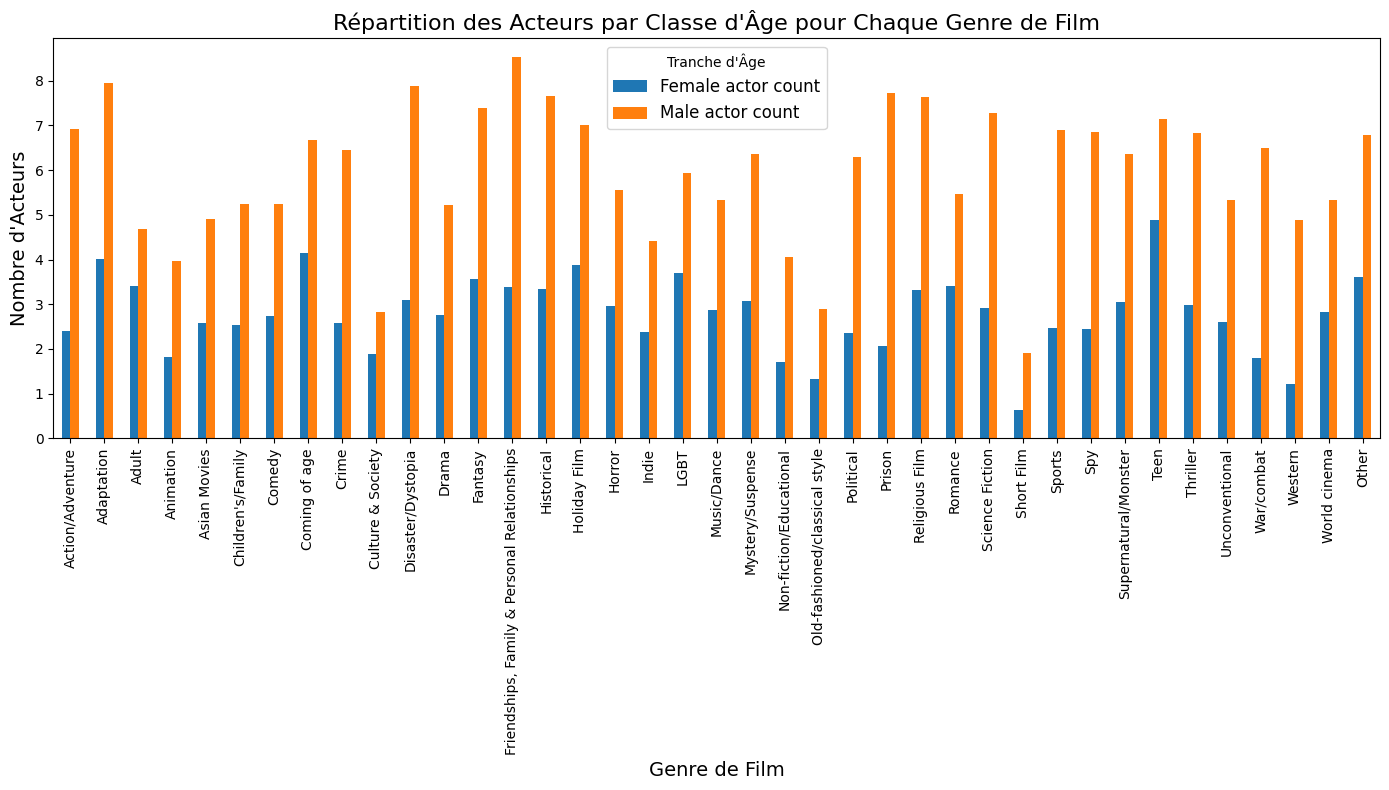

In [31]:
column_names = ['Female actor count', 'Male actor count']
bar_per_genre(MOVIES, NEW_GENRE["categories"], column_names, "Répartition des Acteurs par Classe d'Âge pour Chaque Genre de Film",
                      "Genre de Film", "Nombre d'Acteurs", "Tranche d'Âge", stacked=False)

# Data analysis and visualization examples

### Genre runtime analysis

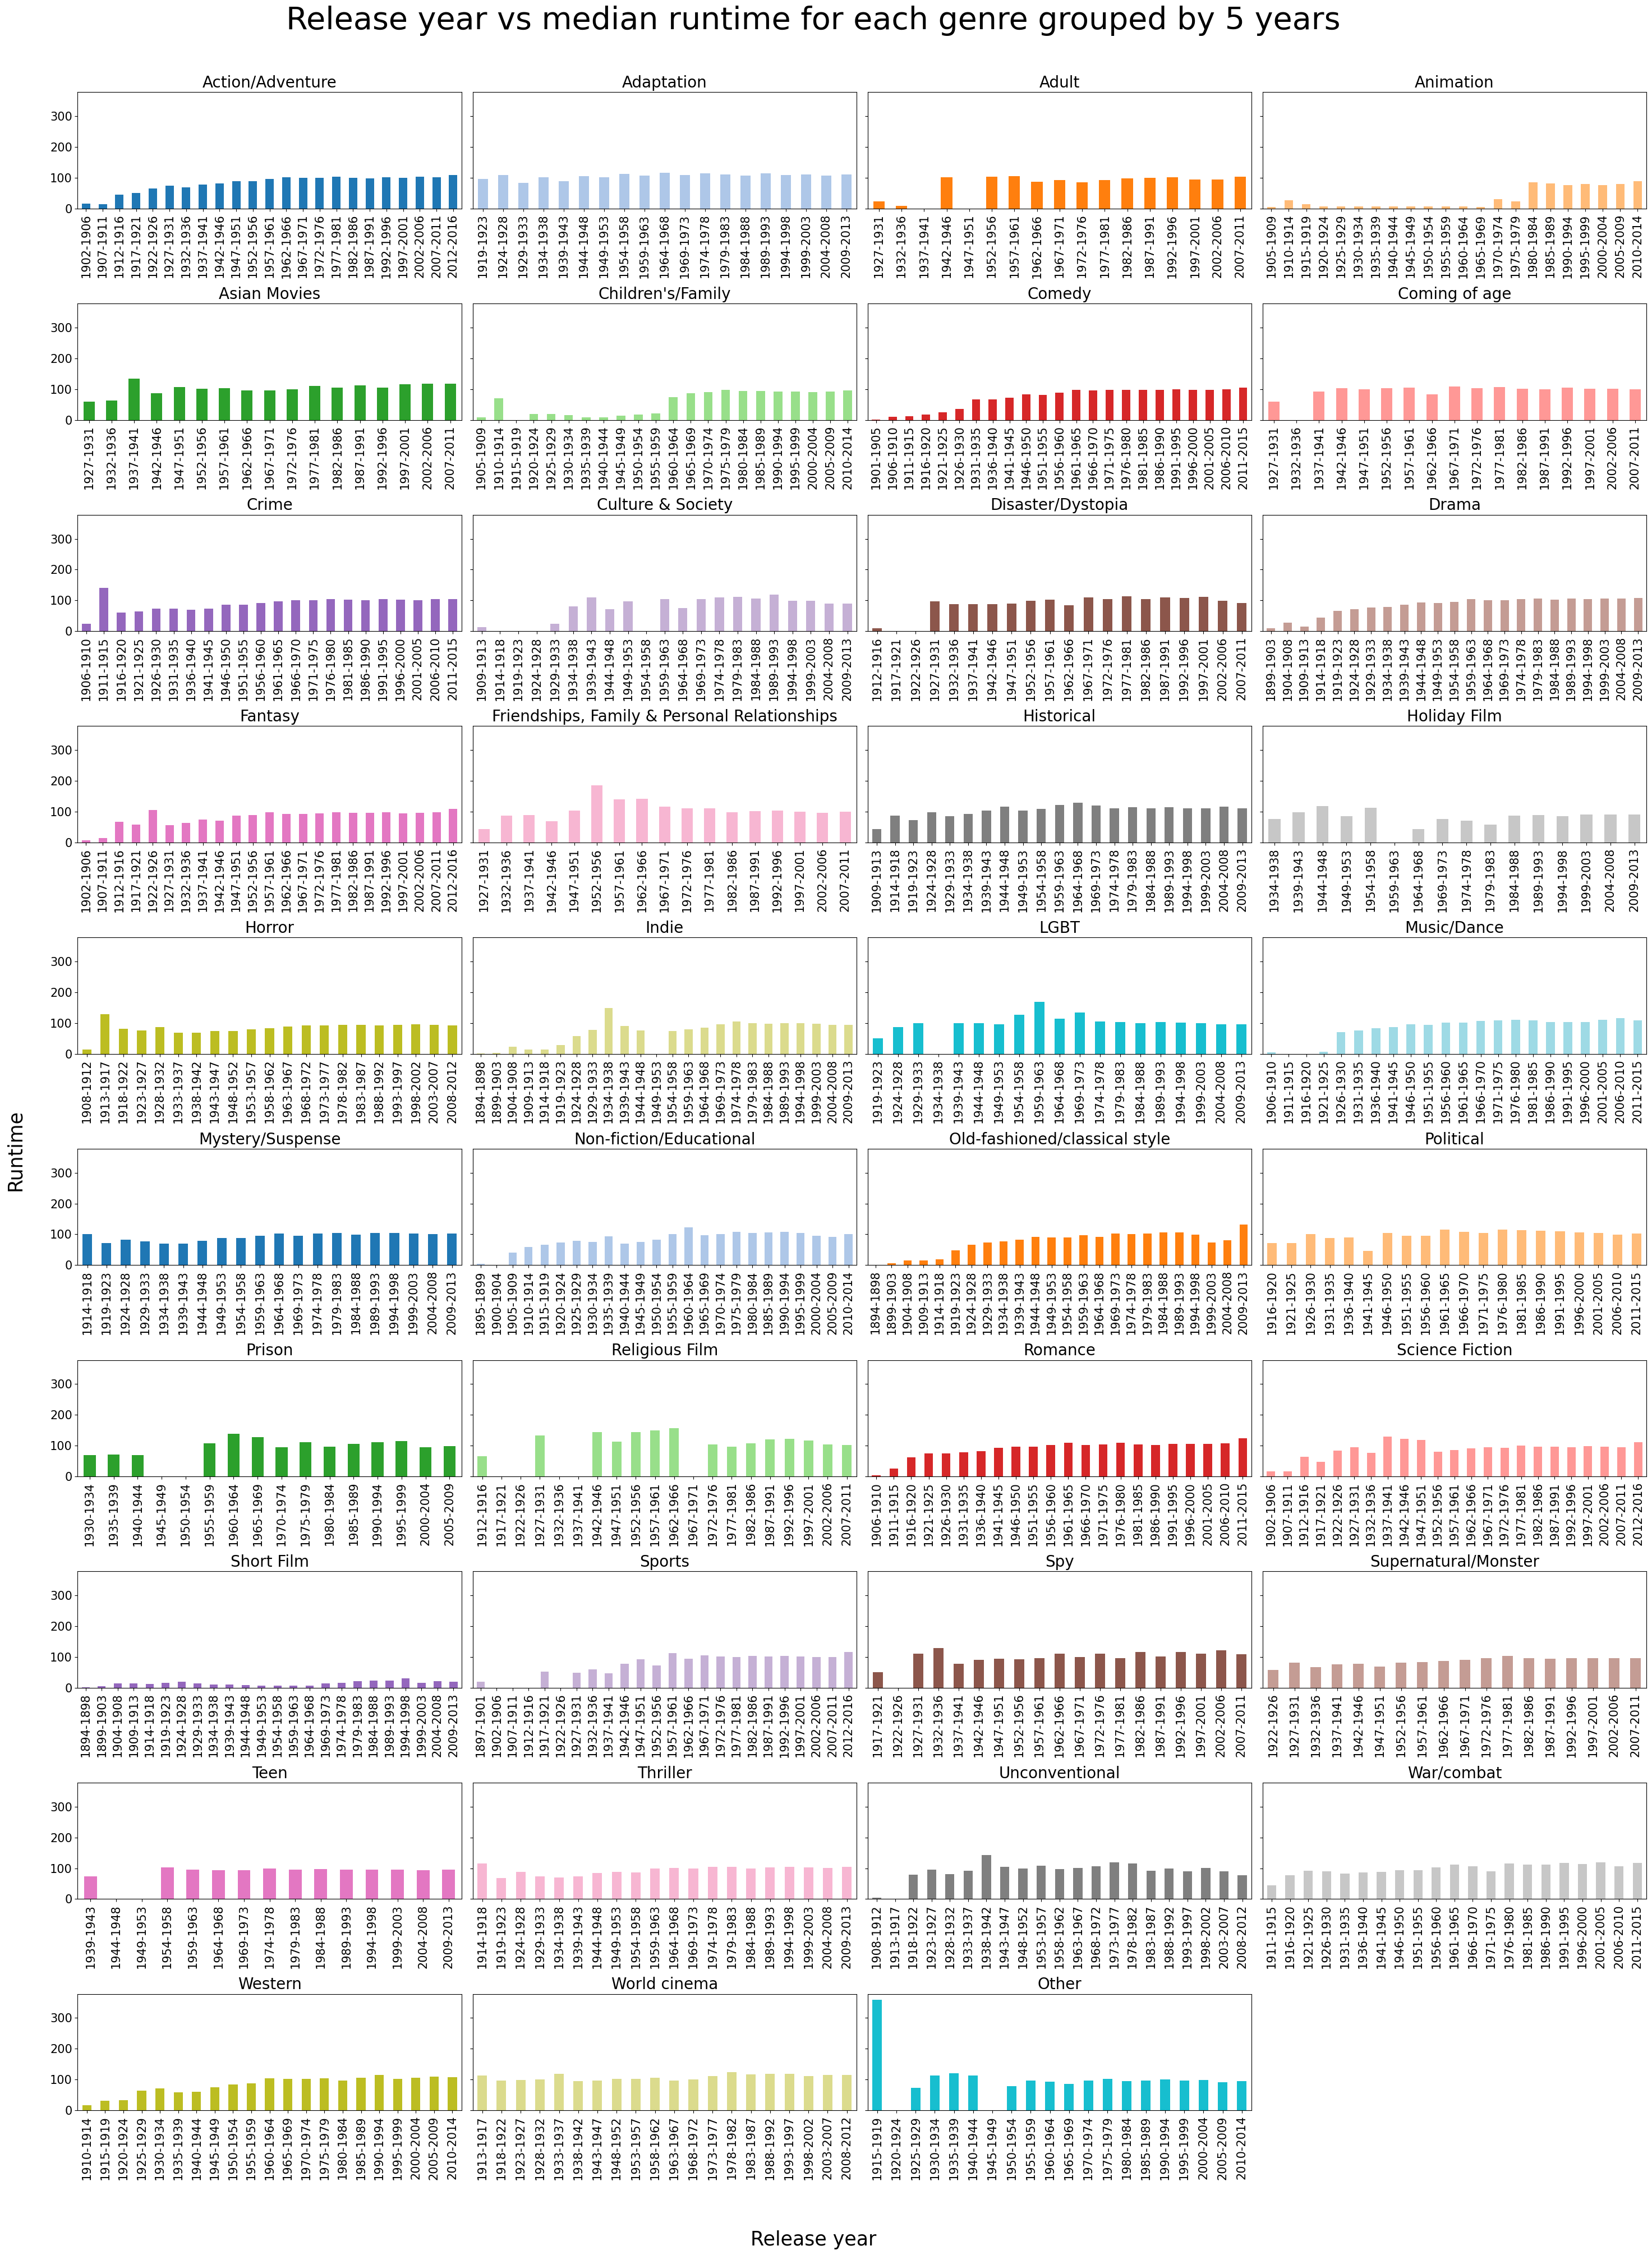

In [32]:
# Bar plot of change in runtime over years for each genre

barplot_per_genre_over_years(MOVIES,  NEW_GENRE["categories"], 5, "runtime", 'Release year vs median runtime for each genre grouped by 5 years')

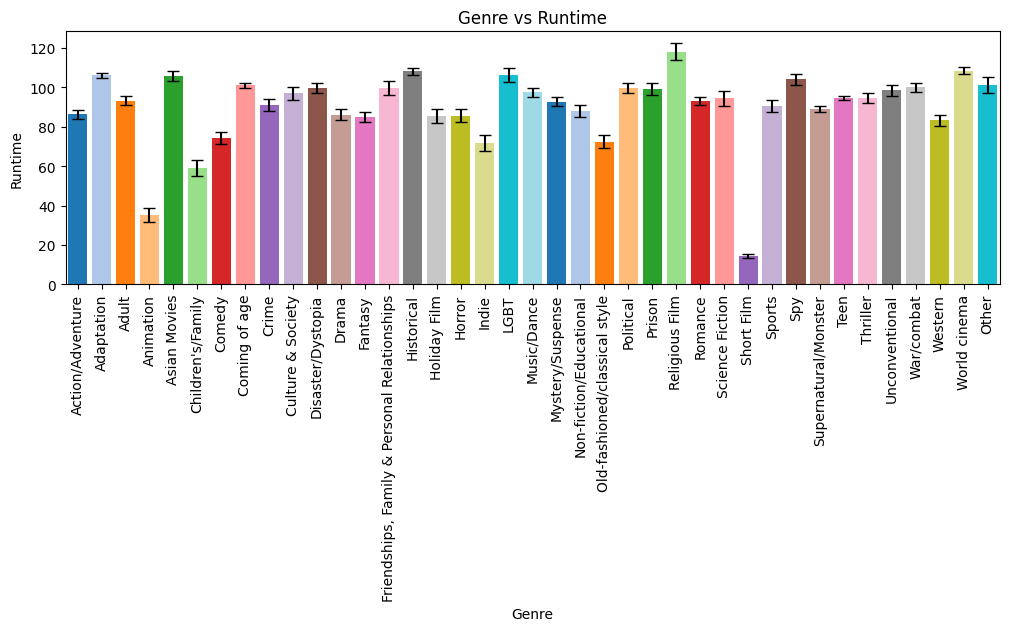

In [33]:
#Runtime average over median each year, with sem errorbars
barplot_means_per_genre(MOVIES, NEW_GENRE["categories"], "runtime", "Genre vs Runtime", median=True, zeros=False)

### Genre revenue analysis

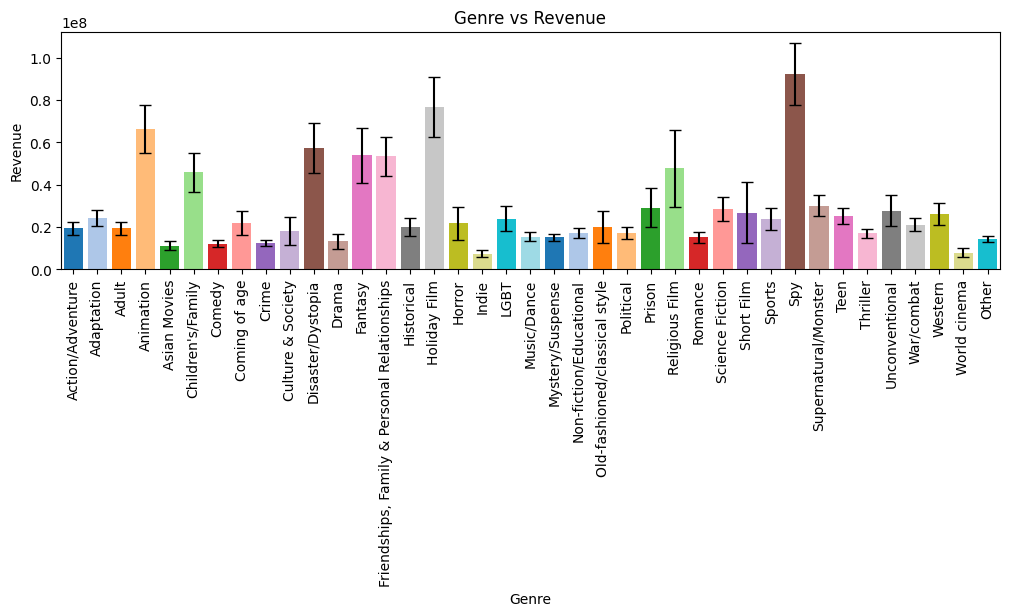

In [34]:
#Genre vs mean of median revenue per year
barplot_means_per_genre(MOVIES, NEW_GENRE["categories"], "revenue", "Genre vs Revenue", median=True, zeros=False)

### Genre and length of synopsis analysis

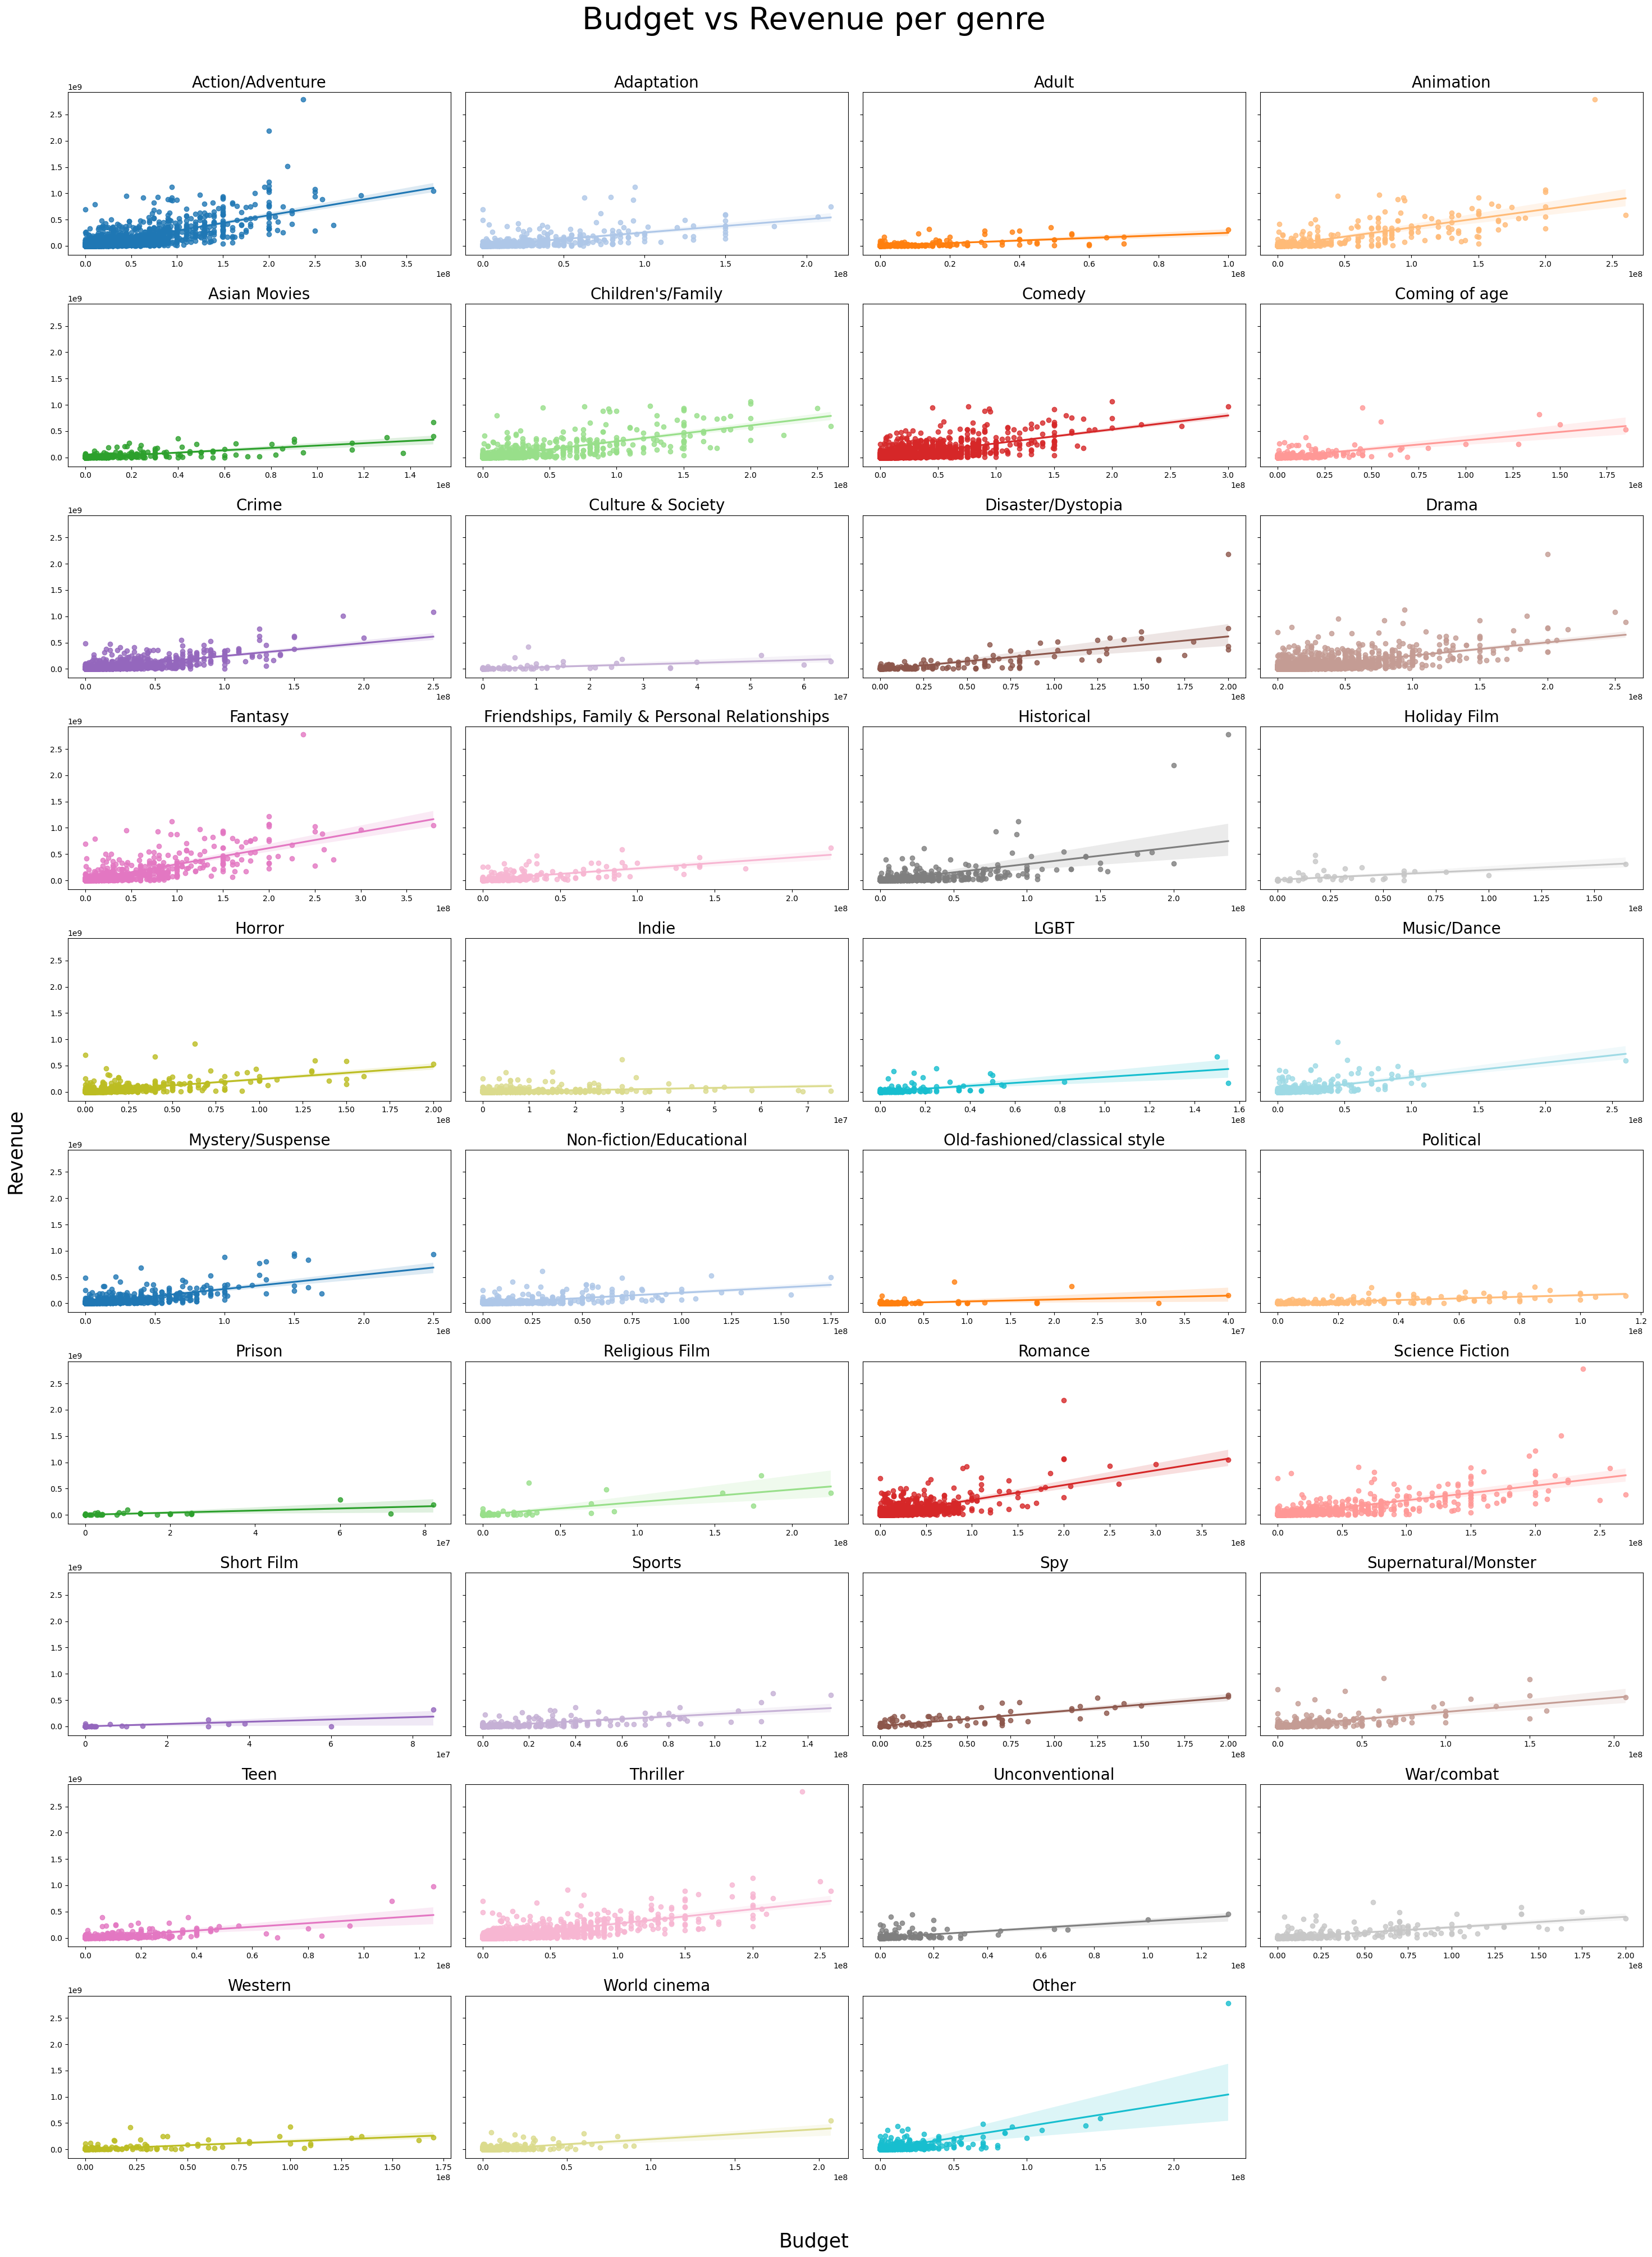

In [35]:
#Plotting budget vs revenue for each genre
pd.options.mode.chained_assignment = None  # default='warn'
scatter_plot_per_genre(MOVIES, NEW_GENRE["categories"], 'budget', 'revenue', 'Budget vs Revenue per genre')

### HEATMAP (╯°□°)╯︵ ┻━┻

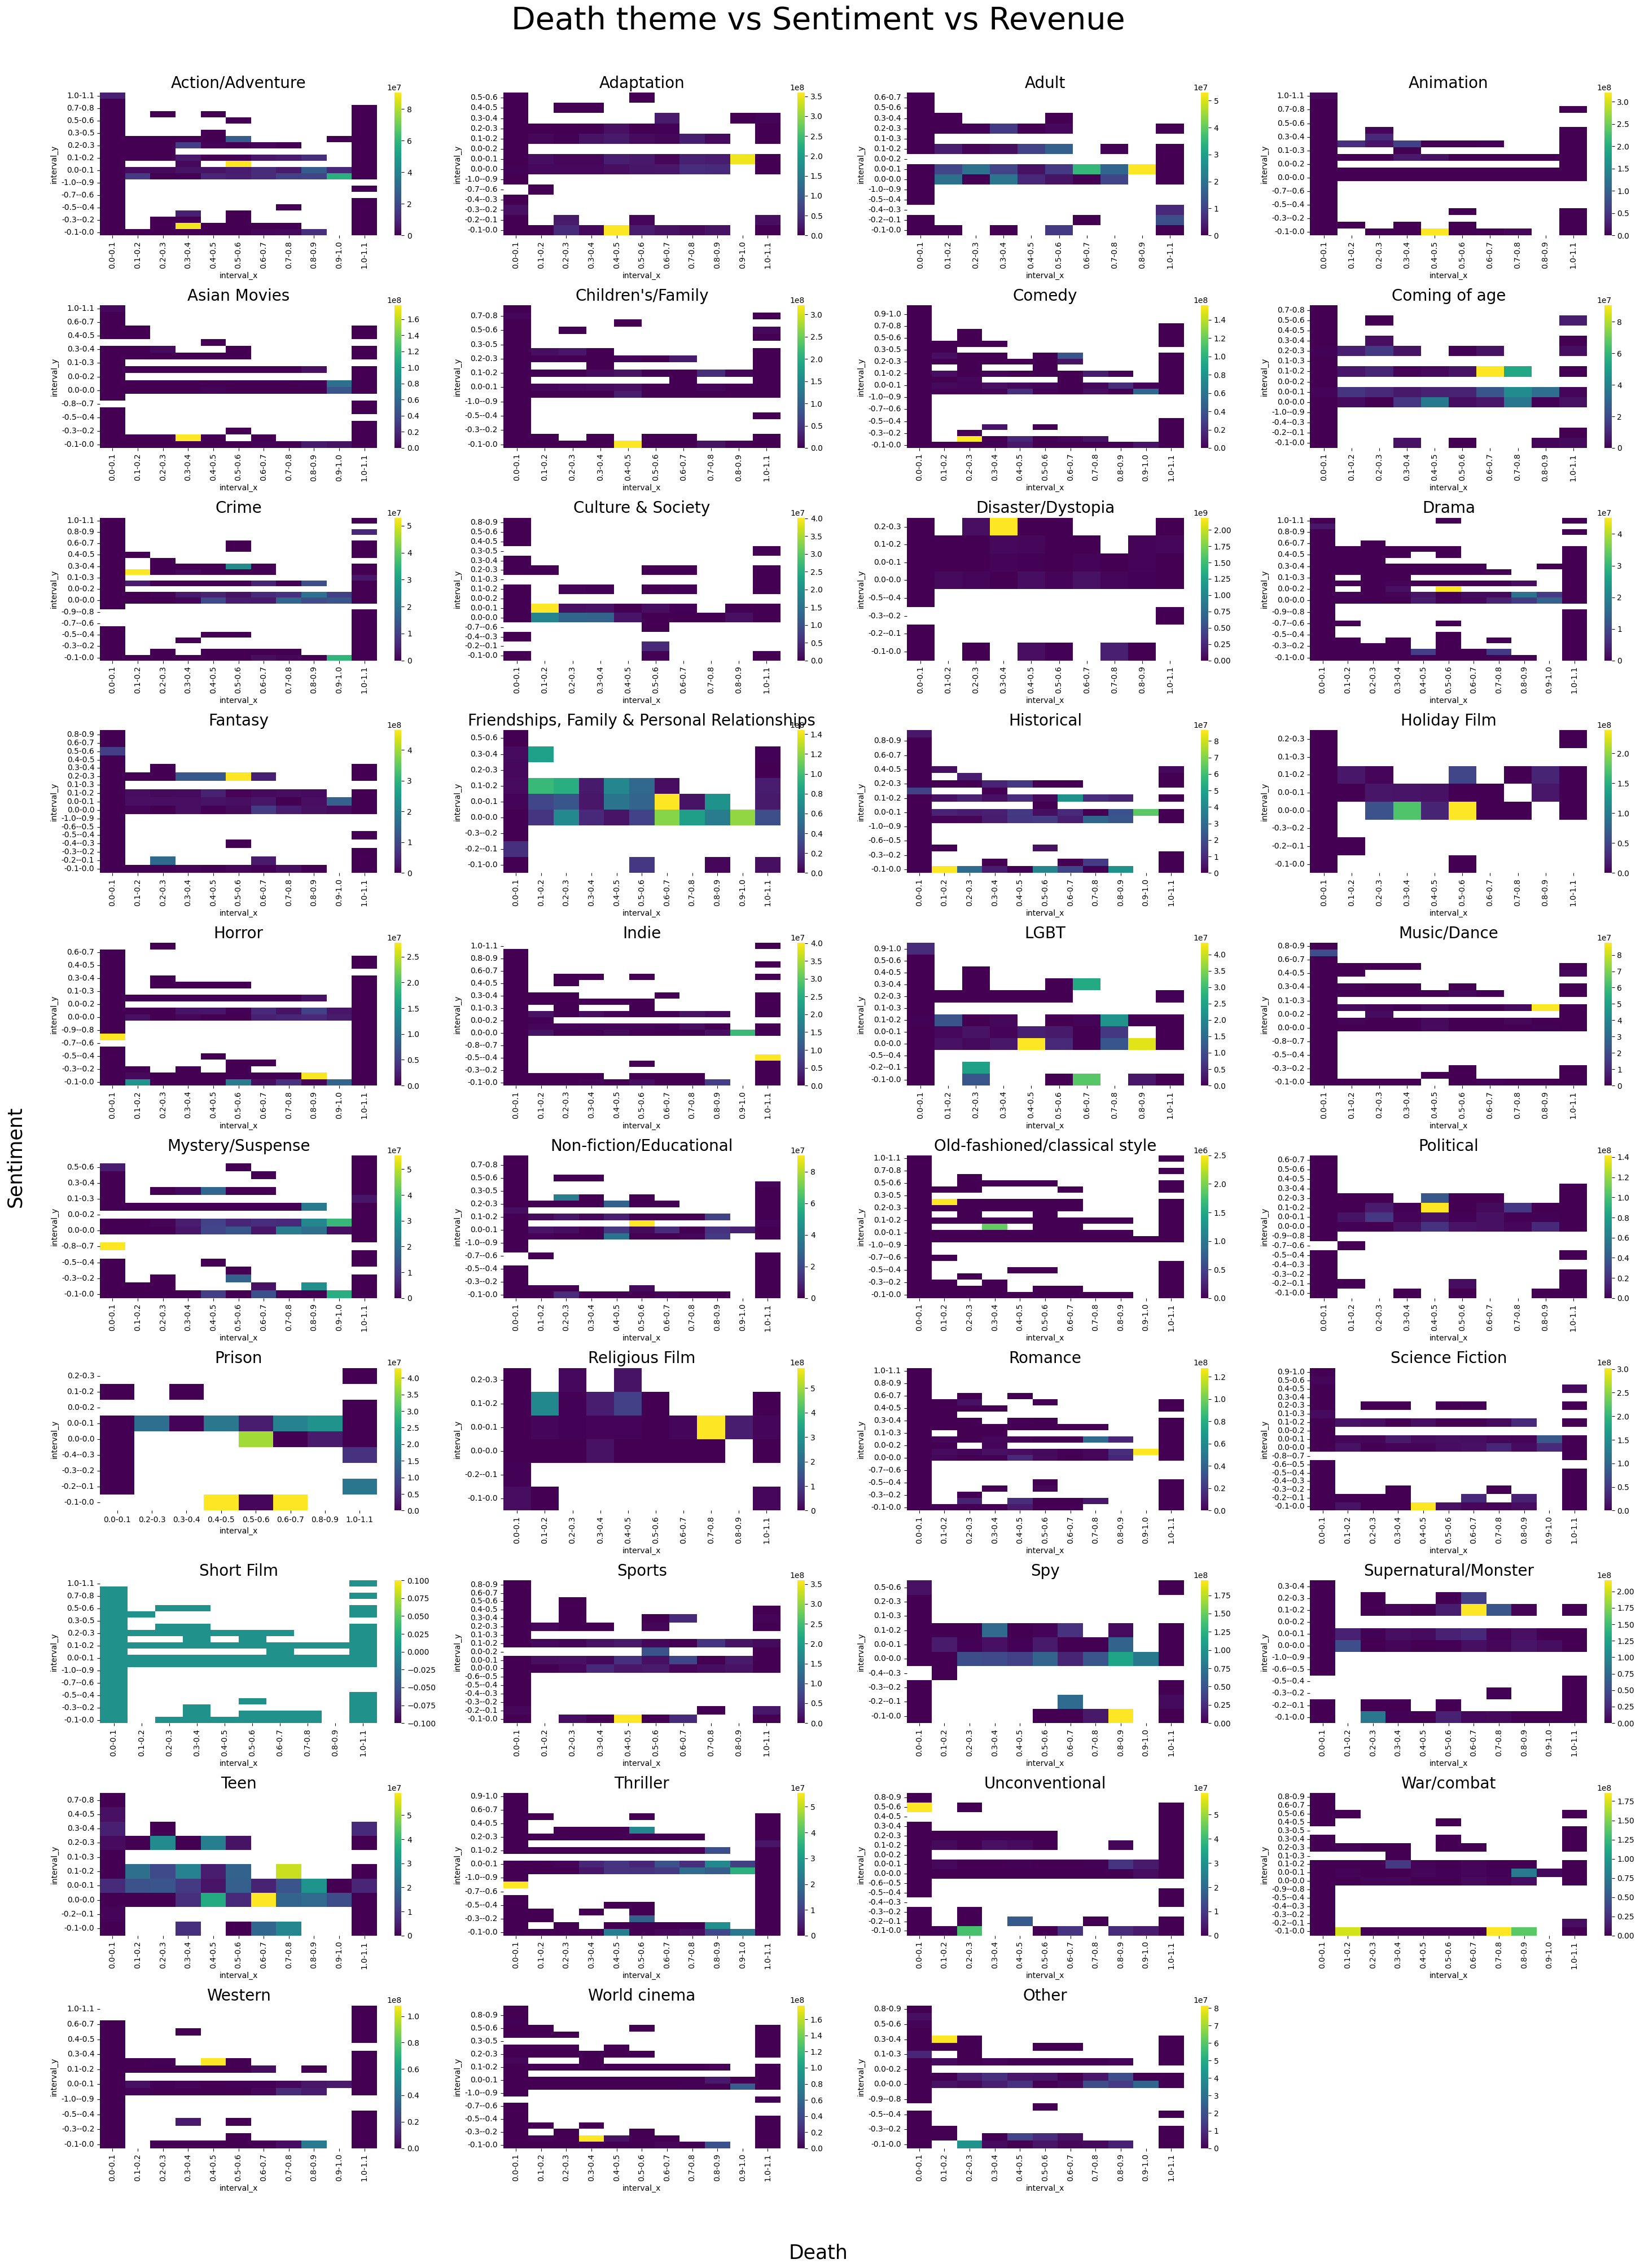

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
heatmap_per_genre(MOVIES, NEW_GENRE["categories"], 'sentiment', 'death', 'revenue', 0.1, 0.1, 'Death theme vs Sentiment vs Revenue')

Semtiment makes no different on the revenue but death topics do

# MOVIE GENRE PREDICTOR MODEL

### Data splitting for crossvalidation

In [38]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'vote_average',
       'vote_count', 'adult', 'budget', 'popularity', 'plot',
       'original_genres', 'new_genres', 'genre_hot', 'death', 'love',
       'tragedy', 'sentiment', 'Character Count', 'Female actor count',
       'Male actor count', 'N/A actor count', 'Actors 0-20', 'Actors 20-30',
       'Actors 30-40', 'Actors 40-60', 'Actors 60+', 'release_decade'],
      dtype='object')

In [39]:
training_columns = [
    "revenue", "runtime", "release_year",  "vote_average", "vote_count", "adult", "budget", "popularity", "sentiment",
    'death', 'love', 'tragedy', 'Character Count', 'Female actor count', 'Male actor count', 'N/A actor count', 
    'Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+'
] 
target_column = ["genre_hot"]
training_set, training_target_set, testing_set, testing_target_set = train_and_test_split(MOVIES, training_columns, target_column, train_proportion =  SETTINGS["MODEL_SETTINGS"]["TEST_PROPORTION"],seed = SETTINGS["MODEL_SETTINGS"]["SEED"],)

### Model

In [40]:
feature_size = len(training_columns)
genre_size = len(NEW_GENRE["subgenres"])

model_factory = lambda: get_model(feature_size, genre_size, SETTINGS["MODEL_SETTINGS"]["LAYER_SIZE"])
model = model_factory()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
model = model.to(device=device)

optimizer_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-3,
)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

### Model training

We use stochastic training for better performance. The batch size is 10 by default.

In [41]:
batches_train, batches_test = get_training_batch(training_set, training_target_set)
# print(f"{batches_train = }")
# print(f"{batches_test = }")

trained_model, train_loss, train_acc, f_score_history, precision_history, recall_history = train_model(
    batches_train, batches_test, model, optimizer, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"], device
) 

Batch loss_float = 8.9562
Batch accuracy = 0.5282
Batch f_score = 0.1064
Batch precision = 0.0632
Batch recall = 0.4917
Batch loss_float = 1.2223
Batch accuracy = 0.9333
Batch f_score = 0.2800
Batch precision = 0.4571
Batch recall = 0.2300
Batch loss_float = 6.7825
Batch accuracy = 0.8872
Batch f_score = 0.1500
Batch precision = 0.2000
Batch recall = 0.1333
Batch loss_float = 7.8312
Batch accuracy = 0.8769
Batch f_score = 0.0982
Batch precision = 0.0762
Batch recall = 0.1450
Batch loss_float = 6.7846
Batch accuracy = 0.8923
Batch f_score = 0.1019
Batch precision = 0.1619
Batch recall = 0.0900
Batch loss_float = 8.1449
Batch accuracy = 0.8897
Batch f_score = 0.0000
Batch precision = 0.0000
Batch recall = 0.0000
Batch loss_float = 7.0154
Batch accuracy = 0.8974
Batch f_score = 0.1373
Batch precision = 0.2033
Batch recall = 0.1094
Batch loss_float = 2.4094
Batch accuracy = 0.9385
Batch f_score = 0.0733
Batch precision = 0.1333
Batch recall = 0.0583
Batch loss_float = 3.9678
Batch accuracy

### Training Plotting

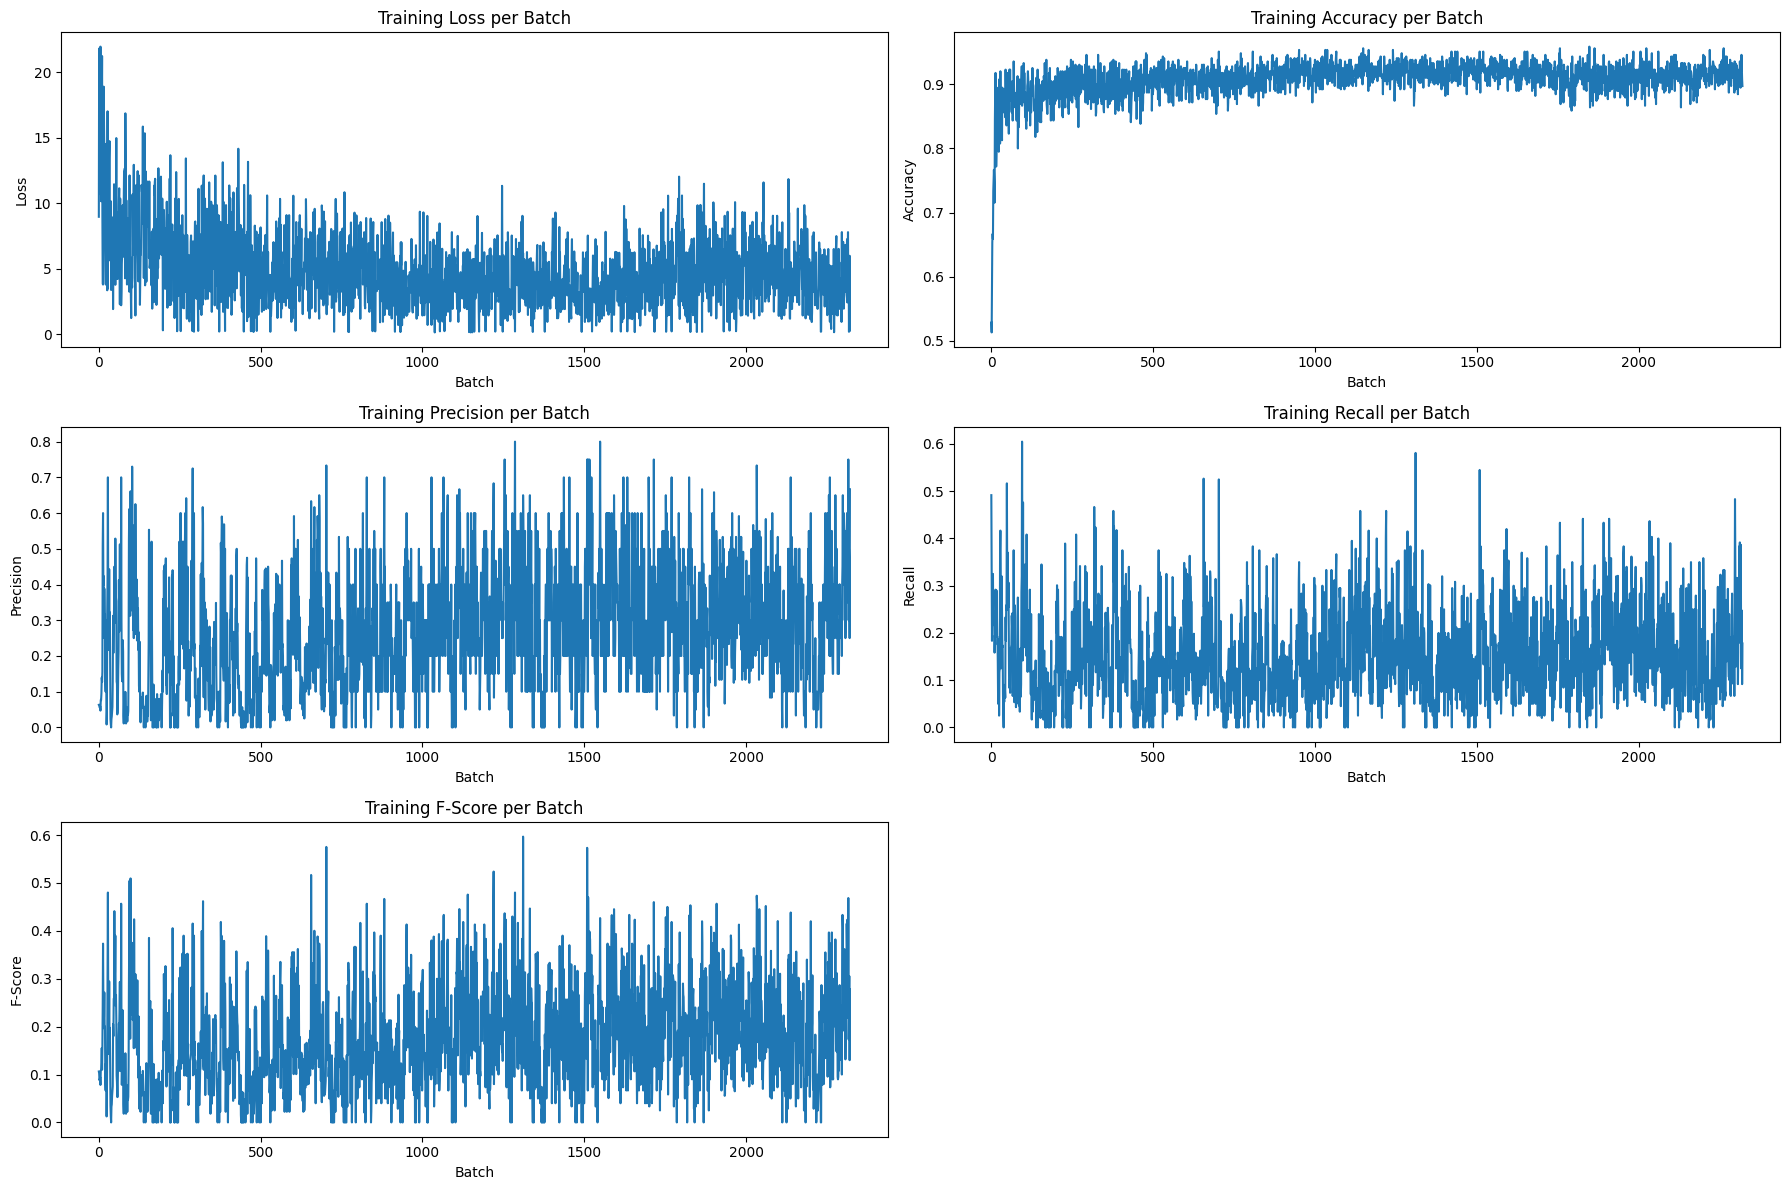

In [42]:
batch_indices = [i for i in range(len(batches_train))]

plt.figure(figsize=(18, 12)) 

plt.subplot(3, 2, 1)
plt.plot(batch_indices, train_loss)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss per Batch")

plt.subplot(3, 2, 2)
plt.plot(batch_indices, train_acc)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Batch")

plt.subplot(3, 2, 3)
plt.plot(batch_indices, precision_history)
plt.xlabel("Batch")
plt.ylabel("Precision")
plt.title("Training Precision per Batch")

plt.subplot(3, 2, 4)
plt.plot(batch_indices, recall_history)
plt.xlabel("Batch")
plt.ylabel("Recall")
plt.title("Training Recall per Batch")

plt.subplot(3, 2, 5)
plt.plot(batch_indices, f_score_history)
plt.xlabel("Batch")
plt.ylabel("F-Score")
plt.title("Training F-Score per Batch")

plt.tight_layout()
plt.show()

In [43]:
del batches_train
del batches_test
del training_set
del training_target_set
del train_loss
del train_acc
del precision_history
del recall_history
del f_score_history
torch.cuda.empty_cache()

### Model testing

In [44]:
testing_set_t = torch.tensor(testing_set[training_columns].values.tolist(), dtype=torch.float32).to(device_cpu)
testing_target_set_t = torch.tensor(testing_target_set.values.tolist(), dtype=torch.float32).to(device_cpu)
trained_model = trained_model.to(device_cpu)

predictions = test_model(trained_model, testing_set_t, testing_target_set_t, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"])

genre_labels = NEW_GENRE["categories"]
predicted_genre = []

for movie_prediction in predictions:
    genres = [genre_labels[i] for i, is_genre in enumerate(movie_prediction) if is_genre == 1]
    predicted_genre.append(genres)

# predictions_df = pd.DataFrame(predictions, columns=genre_labels)
# predicted_genre = predictions_df.apply(
#     lambda row: [genre for genre, is_genre in zip(genre_labels, row) if is_genre == 1],
#     axis=1
# ).tolist()

predictins_output = pd.DataFrame({
    'wikipedia_movie_ID': testing_set["wikipedia_movie_ID"],
    'name': testing_set["name"],
    'original_genres': testing_set["new_genres"],
    'predicted_genres': predicted_genre,
})


predictins_output.to_csv("movies_predicted_genre.csv", index = False)


Testing accuracy = 206749.4011
Testing f_score = 0.0134
Testing precision = 0.0435
Testing recall = 0.0092
